In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm

from sklearn.metrics.pairwise import cosine_distances
import pickle

import matplotlib.pyplot as plt

In [2]:
import torch
from torch import optim
from torch import nn

In [3]:
import warnings
warnings.simplefilter("ignore")

In [4]:
from models import EmbeddingNet, TripletNet
from models import TripletCosLoss

from trainer import get_embedding_for_test_task
from trainer import fit
from trainer import get_distance_distrib, plot_dev_destrib

from quality_utils import print_score

from dataset import TripletDataset

from utils import plotter, show_raw_distrib

In [5]:
iter_train = np.array(pd.read_csv('../data/tmp_data/train65k.csv'))
iter_test = np.array(pd.read_csv('../data/tmp_data/test14k.csv'))

In [6]:
# with open('../data/embeddings_dataset.pkl', 'rb') as f:
#     fst_emb = pickle.load(f)

In [7]:
with open('../data/fasttext_wiki_news_subwords.pkl', 'rb') as f:
    fasttext_wiki_news_subwords = pickle.load(f)
with open('../data/w2v_google_news.pkl', 'rb') as f:
    w2v_google_news = pickle.load(f)
with open('../data/glove_wiki_gigaword.pkl', 'rb') as f:
    glove_wiki_gigaword = pickle.load(f)
with open('../data/glove_google_news_negavite.pkl', 'rb') as f:
    glove_google_news_negavite = pickle.load(f)

(65292,)


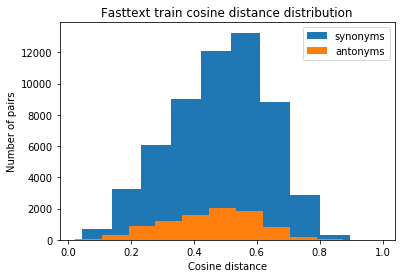

(14788,)


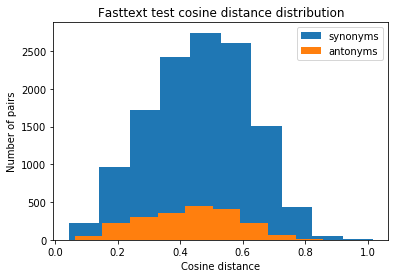

In [8]:
#plt.figure(figsize=(7, 3))
plt.title('Fasttext train cosine distance distribution')
plt.ylabel('Number of pairs')
plt.xlabel('Cosine distance')
show_raw_distrib(iter_train, fasttext_wiki_news_subwords)
#plt.savefig('../images/raw_train_distrib.png')
plt.show()

#plt.figure(figsize=(9, 5))
plt.title('Fasttext test cosine distance distribution')
plt.ylabel('Number of pairs')
plt.xlabel('Cosine distance')
show_raw_distrib(iter_test, fasttext_wiki_news_subwords)
# plt.savefig('../images/raw_test_distrib.png')

(60221,)


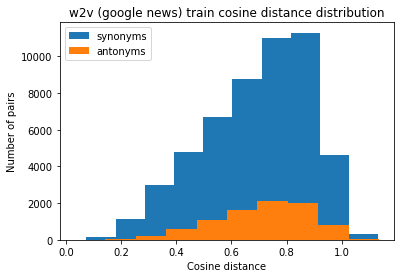

(13379,)


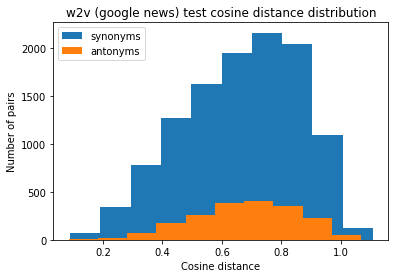

In [9]:
plt.title('w2v (google news) train cosine distance distribution')
plt.ylabel('Number of pairs')
plt.xlabel('Cosine distance')
show_raw_distrib(iter_train, w2v_google_news)
plt.show()

plt.title('w2v (google news) test cosine distance distribution')
plt.ylabel('Number of pairs')
plt.xlabel('Cosine distance')
show_raw_distrib(iter_test, w2v_google_news)


(58686,)


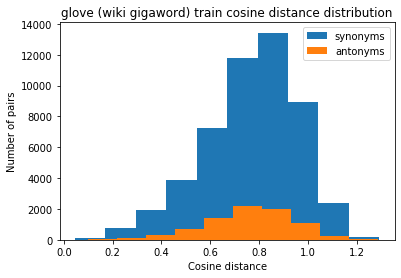

(12989,)


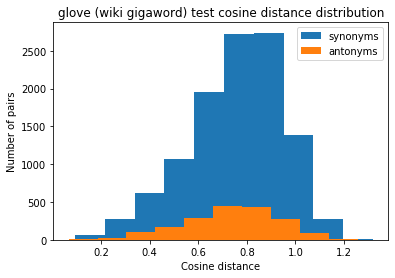

In [10]:
plt.title('glove (wiki gigaword) train cosine distance distribution')
plt.ylabel('Number of pairs')
plt.xlabel('Cosine distance')
show_raw_distrib(iter_train, glove_wiki_gigaword)

plt.show()

plt.title('glove (wiki gigaword) test cosine distance distribution')
plt.ylabel('Number of pairs')
plt.xlabel('Cosine distance')
show_raw_distrib(iter_test, glove_wiki_gigaword)


(60221,)


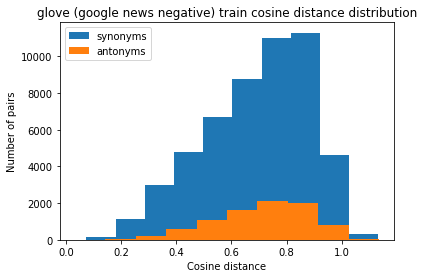

(13379,)


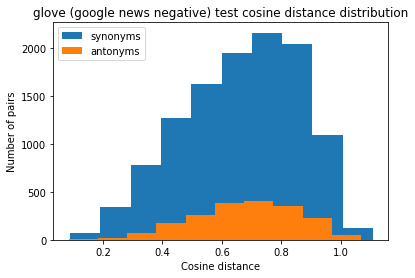

In [11]:
plt.title('glove (google news negative) train cosine distance distribution')
plt.ylabel('Number of pairs')
plt.xlabel('Cosine distance')
show_raw_distrib(iter_train, glove_google_news_negavite)
plt.show()

plt.title('glove (google news negative) test cosine distance distribution')
plt.ylabel('Number of pairs')
plt.xlabel('Cosine distance')
show_raw_distrib(iter_test, glove_google_news_negavite)

In [12]:
# plt.figure(figsize=(15, 5))
# plt.subplot(121)
# show_raw_distrib(iter_train, fst_emb)
# plt.subplot(122)
# show_raw_distrib(iter_test, fst_emb)

In [13]:
def get_train_val_val_test(train, test, emb):
    train_triplet_dataloader = torch.utils.data.DataLoader(TripletDataset(train, emb, is_triplet=True), 
                                                    batch_size=64, 
                                                    shuffle=False, 
                                                    num_workers=0)


    val_triplet_dataloader = torch.utils.data.DataLoader(TripletDataset(test, emb, is_triplet=True), 
                                                    batch_size=64, 
                                                    shuffle=False, 
                                                    num_workers=0)

    val_pair_dataloader = torch.utils.data.DataLoader(TripletDataset(test, emb, is_triplet=False,stack_samples=False), 
                                                    batch_size=64, 
                                                    shuffle=False, 
                                                    num_workers=0)


    test_dataset = TripletDataset(test, emb, is_triplet=False, stack_samples=False)
    return train_triplet_dataloader, val_triplet_dataloader, val_pair_dataloader,test_dataset


In [14]:
train_triplet_dataloader, val_triplet_dataloader, val_pair_dataloader,test_dataset=get_train_val_val_test(iter_train, iter_test,fasttext_wiki_news_subwords)

100%|████████████████████████████████████████████████████████████████████████| 14788/14788 [00:00<00:00, 449325.69it/s]


## fasttext

In [16]:
embedding_net = EmbeddingNet()
model = TripletNet(embedding_net).to(device='cuda');
loss_fn = TripletCosLoss(margin=1.)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

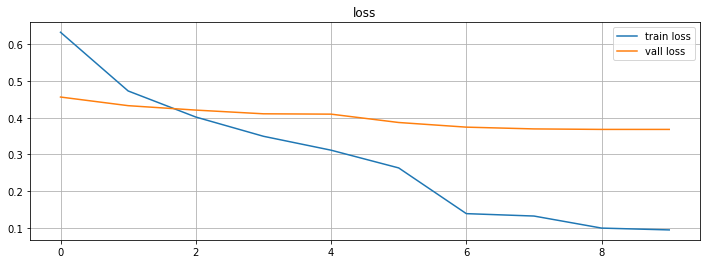

Epoch 0
Train Loss: 0.6328 | Val Loss: 0.4563

Epoch 1
Train Loss: 0.4729 | Val Loss: 0.4328

Epoch 2
Train Loss: 0.4018 | Val Loss: 0.4207

Epoch 3
Train Loss: 0.3494 | Val Loss: 0.4106

Epoch 4
Train Loss: 0.3115 | Val Loss: 0.4097

Epoch 5
Train Loss: 0.2632 | Val Loss: 0.3869

Epoch 10
Train Loss: 0.1387 | Val Loss: 0.3743

Epoch 11
Train Loss: 0.1321 | Val Loss: 0.3695

Epoch 73
Train Loss: 0.0993 | Val Loss: 0.3681

Epoch 144
Train Loss: 0.0943 | Val Loss: 0.3681



In [17]:
fit(train_dataloader=train_triplet_dataloader, 
    val_dataloader=val_triplet_dataloader, 
    model=model,
    optimizer=optimizer,
    loss_fn=loss_fn,
    n_epochs = 150,
   with_scheduler=True)

Dist iteration: 100%|████████████████████████████████████████████████████████████████| 232/232 [00:03<00:00, 61.72it/s]


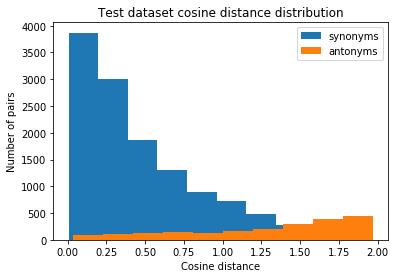

In [18]:
plt.title('Test dataset cosine distance distribution')
plt.ylabel('Number of pairs')
plt.xlabel('Cosine distance')
plot_dev_destrib(model=model, dev_dataloader=val_pair_dataloader)


In [19]:
x_raw, x_model, x_model_raw, y = get_embedding_for_test_task(model, test_dataset)
print_score(x_model, x_raw, x_model_raw, y)

100%|███████████████████████████████████████████████████████████████████████████| 14788/14788 [00:31<00:00, 469.45it/s]


LogisticRegression
model
0.7265938374401685 [0.69331307 0.73944917 0.74701927]
raw
0.7287298225719504 [0.69618811 0.70870415 0.7812972 ]
raw + model
0.7368340831328091 [0.70688112 0.71559912 0.78802201]

XGBoost
model
0.8827553903601496 [0.87133705 0.91120939 0.86571973]
raw
0.7315159727694271 [0.66798902 0.72997011 0.79658878]
raw + model
0.8529266905050877 [0.80813273 0.87099797 0.87964937]


In [20]:
# torch.save(model, '../models/TripletCosNet_align_25ep.model')

In [21]:
def crop_data(data, emb):
    ukeys = np.unique(list(emb.keys()))
    crop_data = []
    for w0,w1,r in tqdm(data):
        if (w0 not in ukeys) or (w1 not in ukeys):
            continue
        crop_data.append([w0,w1,r])
    return(np.array(crop_data))



## w2v google news

In [22]:
crop_iter_train = crop_data(iter_train, w2v_google_news)
crop_iter_test = crop_data(iter_test, w2v_google_news)

100%|██████████████████████████████████████████████████████████████████████████| 14788/14788 [00:06<00:00, 2166.50it/s]


In [23]:
train_triplet_dataloader, val_triplet_dataloader, val_pair_dataloader, test_dataset = get_train_val_val_test(crop_iter_train, crop_iter_test,w2v_google_news)

100%|████████████████████████████████████████████████████████████████████████| 13379/13379 [00:00<00:00, 223579.68it/s]


In [24]:
embedding_net = EmbeddingNet()
model = TripletNet(embedding_net).to(device='cuda');
loss_fn = TripletCosLoss(margin=1.)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

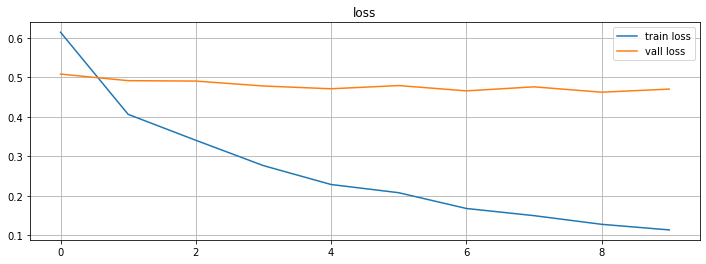

Epoch 0
Train Loss: 0.6140 | Val Loss: 0.5081

Epoch 1
Train Loss: 0.4062 | Val Loss: 0.4915

Epoch 2
Train Loss: 0.3405 | Val Loss: 0.4904

Epoch 3
Train Loss: 0.2763 | Val Loss: 0.4780

Epoch 4
Train Loss: 0.2285 | Val Loss: 0.4709

Epoch 5
Train Loss: 0.2077 | Val Loss: 0.4790

Epoch 6
Train Loss: 0.1678 | Val Loss: 0.4656

Epoch 7
Train Loss: 0.1497 | Val Loss: 0.4758

Epoch 8
Train Loss: 0.1277 | Val Loss: 0.4622

Epoch 9
Train Loss: 0.1135 | Val Loss: 0.4701



In [25]:
fit(train_dataloader=train_triplet_dataloader, 
    val_dataloader=val_triplet_dataloader, 
    model=model,
    optimizer=optimizer,
    loss_fn=loss_fn,
    n_epochs = 10)

Dist iteration: 100%|████████████████████████████████████████████████████████████████| 210/210 [00:03<00:00, 63.48it/s]


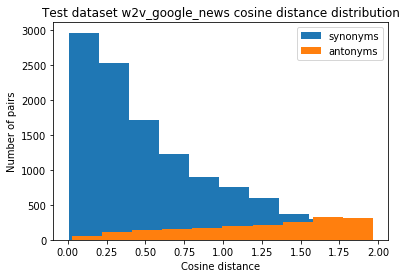

In [26]:
plt.title('Test dataset w2v_google_news cosine distance distribution')
plt.ylabel('Number of pairs')
plt.xlabel('Cosine distance')
plot_dev_destrib(model=model, dev_dataloader=val_pair_dataloader)


In [27]:
x_raw, x_model, x_model_raw, y = get_embedding_for_test_task(model, test_dataset)
print_score(x_model, x_raw, x_model_raw, y)

100%|███████████████████████████████████████████████████████████████████████████| 13379/13379 [00:27<00:00, 487.47it/s]


LogisticRegression
model
0.6974033150737665 [0.65037385 0.72773122 0.71410488]
raw
0.6735763054647554 [0.64304004 0.67062057 0.70706831]
raw + model
0.6724822728310377 [0.63954153 0.66709537 0.71080992]

XGBoost
model
0.843477462948876 [0.82442924 0.87915607 0.82684707]
raw
0.6721159009831692 [0.59026037 0.67328983 0.7527975 ]
raw + model
0.7822488997342268 [0.71773218 0.7837943  0.84522022]


## glove google gigawords

In [31]:
crop_iter_train = crop_data(iter_train, glove_wiki_gigaword)
crop_iter_test = crop_data(iter_test, glove_wiki_gigaword)

100%|██████████████████████████████████████████████████████████████████████████| 14788/14788 [00:06<00:00, 2196.02it/s]


In [32]:
train_triplet_dataloader, val_triplet_dataloader, val_pair_dataloader, test_dataset = get_train_val_val_test(crop_iter_train, crop_iter_test,glove_wiki_gigaword)

100%|████████████████████████████████████████████████████████████████████████| 12989/12989 [00:00<00:00, 250456.57it/s]


In [33]:
embedding_net = EmbeddingNet()
model = TripletNet(embedding_net).to(device='cuda');
loss_fn = TripletCosLoss(margin=1.)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

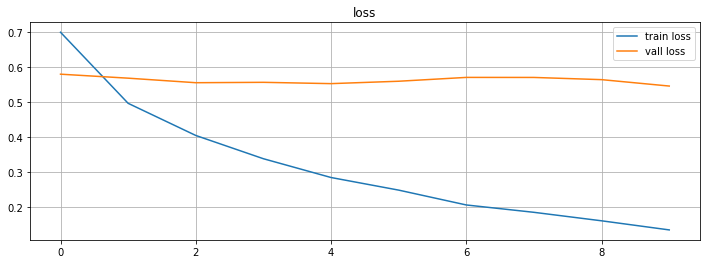

Epoch 0
Train Loss: 0.6989 | Val Loss: 0.5790

Epoch 1
Train Loss: 0.4957 | Val Loss: 0.5676

Epoch 2
Train Loss: 0.4038 | Val Loss: 0.5546

Epoch 3
Train Loss: 0.3373 | Val Loss: 0.5557

Epoch 4
Train Loss: 0.2837 | Val Loss: 0.5520

Epoch 5
Train Loss: 0.2476 | Val Loss: 0.5588

Epoch 6
Train Loss: 0.2052 | Val Loss: 0.5698

Epoch 7
Train Loss: 0.1842 | Val Loss: 0.5697

Epoch 8
Train Loss: 0.1599 | Val Loss: 0.5634

Epoch 9
Train Loss: 0.1339 | Val Loss: 0.5451



In [34]:
fit(train_dataloader=train_triplet_dataloader, 
    val_dataloader=val_triplet_dataloader, 
    model=model,
    optimizer=optimizer,
    loss_fn=loss_fn,
    n_epochs = 10)

Dist iteration: 100%|████████████████████████████████████████████████████████████████| 203/203 [00:03<00:00, 62.76it/s]


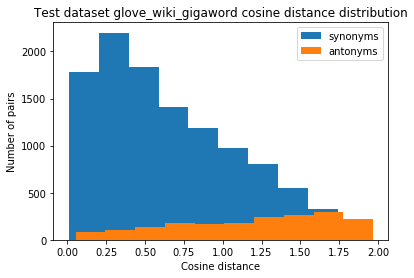

In [35]:
plt.title('Test dataset glove_wiki_gigaword cosine distance distribution')
plt.ylabel('Number of pairs')
plt.xlabel('Cosine distance')
plot_dev_destrib(model=model, dev_dataloader=val_pair_dataloader)


In [36]:
x_raw, x_model, x_model_raw, y = get_embedding_for_test_task(model, test_dataset)
print_score(x_model, x_raw, x_model_raw, y)

100%|███████████████████████████████████████████████████████████████████████████| 12989/12989 [00:26<00:00, 488.47it/s]


LogisticRegression
model
0.6590727708720049 [0.61244341 0.68687454 0.67790036]
raw
0.640440417281574 [0.60529225 0.62846185 0.68756715]
raw + model
0.6456500346207871 [0.60759775 0.63624475 0.6931076 ]

XGBoost
model
0.7582743805019422 [0.72903332 0.795287   0.75050282]
raw
0.6480444433354873 [0.55834171 0.6531544  0.73263722]
raw + model
0.730239659825779 [0.65031681 0.74108646 0.79931571]


## glove google news

In [41]:
crop_iter_train = crop_data(iter_train, glove_google_news_negavite)
crop_iter_test = crop_data(iter_test, glove_google_news_negavite)

100%|██████████████████████████████████████████████████████████████████████████| 14788/14788 [00:06<00:00, 2162.08it/s]


In [42]:
train_triplet_dataloader, val_triplet_dataloader, val_pair_dataloader, test_dataset = get_train_val_val_test(crop_iter_train, crop_iter_test,glove_google_news_negavite)

100%|████████████████████████████████████████████████████████████████████████| 13379/13379 [00:00<00:00, 203254.03it/s]


In [43]:
embedding_net = EmbeddingNet()
model = TripletNet(embedding_net).to(device='cuda');
loss_fn = TripletCosLoss(margin=1.)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

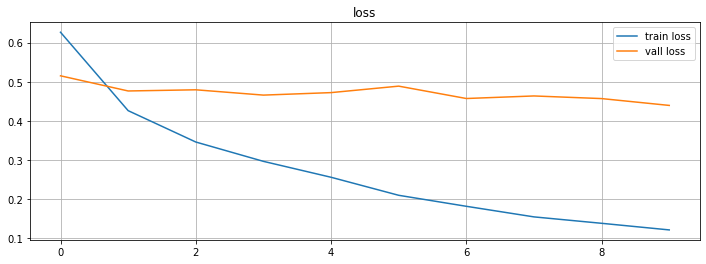

Epoch 0
Train Loss: 0.6262 | Val Loss: 0.5151

Epoch 1
Train Loss: 0.4261 | Val Loss: 0.4763

Epoch 2
Train Loss: 0.3460 | Val Loss: 0.4793

Epoch 3
Train Loss: 0.2967 | Val Loss: 0.4658

Epoch 4
Train Loss: 0.2560 | Val Loss: 0.4721

Epoch 5
Train Loss: 0.2100 | Val Loss: 0.4887

Epoch 6
Train Loss: 0.1819 | Val Loss: 0.4571

Epoch 7
Train Loss: 0.1549 | Val Loss: 0.4636

Epoch 8
Train Loss: 0.1385 | Val Loss: 0.4569

Epoch 9
Train Loss: 0.1217 | Val Loss: 0.4395



In [44]:
fit(train_dataloader=train_triplet_dataloader, 
    val_dataloader=val_triplet_dataloader, 
    model=model,
    optimizer=optimizer,
    loss_fn=loss_fn,
    n_epochs = 10)

Dist iteration: 100%|████████████████████████████████████████████████████████████████| 210/210 [00:03<00:00, 60.58it/s]


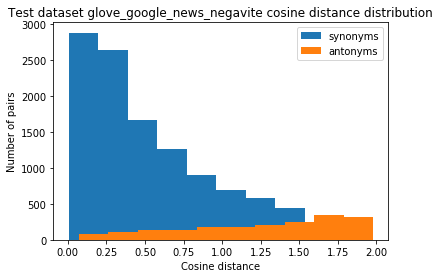

In [45]:
plt.title('Test dataset glove_google_news_negavite cosine distance distribution')
plt.ylabel('Number of pairs')
plt.xlabel('Cosine distance')
plot_dev_destrib(model=model, dev_dataloader=val_pair_dataloader)


In [46]:
x_raw, x_model, x_model_raw, y = get_embedding_for_test_task(model, test_dataset)
print_score(x_model, x_raw, x_model_raw, y)

100%|███████████████████████████████████████████████████████████████████████████| 13379/13379 [00:27<00:00, 485.78it/s]


LogisticRegression
model
0.6988599076069136 [0.65140525 0.71875226 0.72642222]
raw
0.6735763054647554 [0.64304004 0.67062057 0.70706831]
raw + model
0.6785779667866955 [0.64607763 0.67487029 0.71478598]

XGBoost
model
0.8402511885613014 [0.82219704 0.86593953 0.832617  ]
raw
0.6721159009831692 [0.59026037 0.67328983 0.7527975 ]
raw + model
0.7919460211229725 [0.74656001 0.79066881 0.83860924]
